In [1]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=476c3cb42b3505c6fdb5e781bb89f85cf7c6e7f575f8c73e316251481de8c458
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=6a00943

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(seed)

In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
mkdir ~/.kaggle

In [7]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download franciscoescobar/satellite-images-of-water-bodies

100% 246M/247M [00:14<00:00, 23.3MB/s]
100% 247M/247M [00:14<00:00, 18.0MB/s]


In [9]:
! unzip satellite-images-of-water-bodies.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body

In [10]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img, mask=np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [11]:
from sklearn.model_selection import train_test_split

base_path = "Water Bodies Dataset"
images = sorted(glob.glob('Water Bodies Dataset/Images/*'))
masks = sorted(glob.glob('Water Bodies Dataset/Masks/*'))

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=seed)

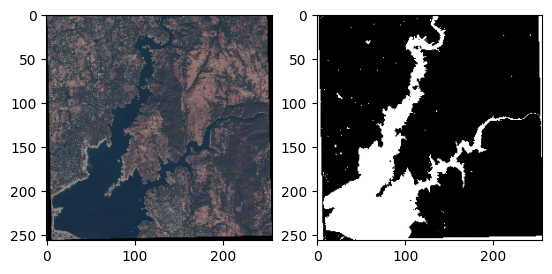

In [12]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

img, mask = train_dataset[seed]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)));

In [13]:
sample_num = 13
EPOCHS=50
BATCH_SIZE=32
LR=0.001

ratio=0.5

ENCODER='resnet18'
WEIGHTS='imagenet'

In [14]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [15]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [16]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            decoder_attention_type = "scse",
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)
        if masks != None:
            loss = DiceLoss(mode='binary')(logits,masks)
            return logits,loss
        return logits

In [17]:
model=SegmentationModel()
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 379MB/s]


In [18]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(device, dtype=torch.float32)
        masks=masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss = model(images,masks)
        diceloss.backward(retain_graph=True)

        optimizer.step()
        total_diceloss+=diceloss.item()
        
    return total_diceloss/len(data_loader)

In [19]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0

    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(device, dtype=torch.float32)
            masks=masks.to(device, dtype=torch.float32)

            logits,diceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to(device, dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
            plt.show()
            
    return total_diceloss/len(data_loader)


In [20]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


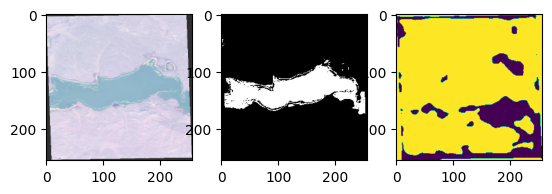

Epochs:1
Train_loss --> Dice: 0.327939672768116 
Valid_loss --> Dice: 0.33152542511622113
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


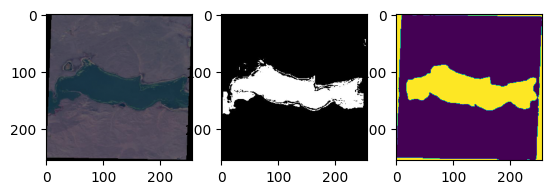

Epochs:2
Train_loss --> Dice: 0.2151683270931244 
Valid_loss --> Dice: 0.20325911045074463
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


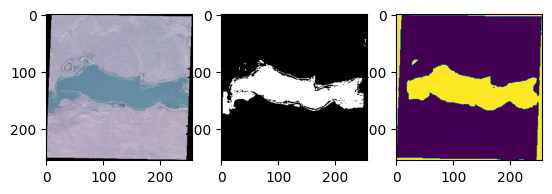

Epochs:3
Train_loss --> Dice: 0.19115077704191208 
Valid_loss --> Dice: 0.24446472194459704


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


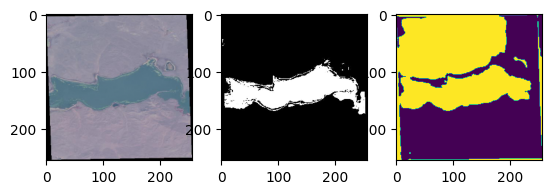

Epochs:4
Train_loss --> Dice: 0.18476589396595955 
Valid_loss --> Dice: 0.2297439906332228


100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


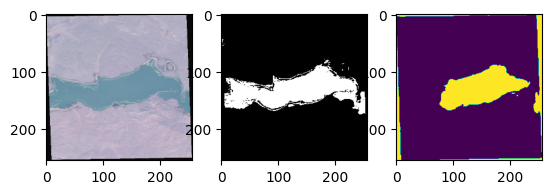

Epochs:5
Train_loss --> Dice: 0.17597481533885 
Valid_loss --> Dice: 0.18965882062911987
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


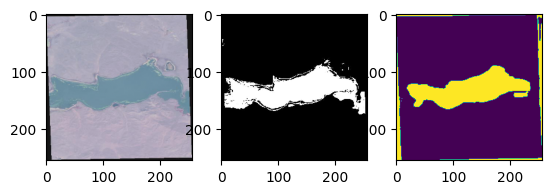

Epochs:6
Train_loss --> Dice: 0.17623553276062012 
Valid_loss --> Dice: 0.257543683052063


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


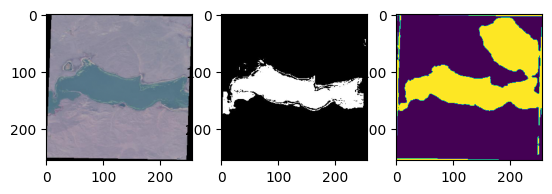

Epochs:7
Train_loss --> Dice: 0.16936507299542428 
Valid_loss --> Dice: 0.1919706662495931


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


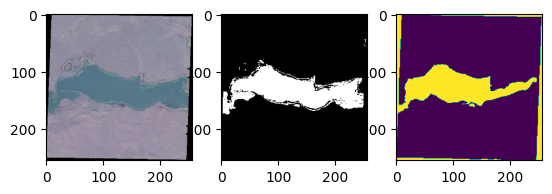

Epochs:8
Train_loss --> Dice: 0.1644750066101551 
Valid_loss --> Dice: 0.20388931698269314


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


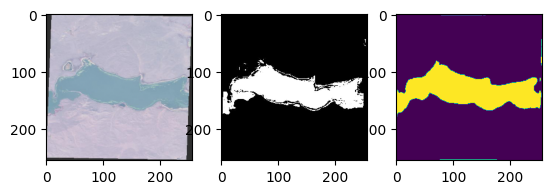

Epochs:9
Train_loss --> Dice: 0.17020338997244835 
Valid_loss --> Dice: 0.16607804430855644
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


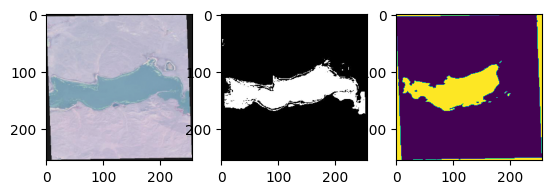

Epochs:10
Train_loss --> Dice: 0.165708776563406 
Valid_loss --> Dice: 0.19739951690038046


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


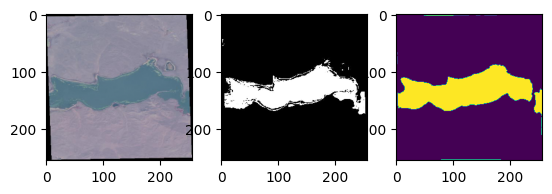

Epochs:11
Train_loss --> Dice: 0.1619940347969532 
Valid_loss --> Dice: 0.16344375080532497
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


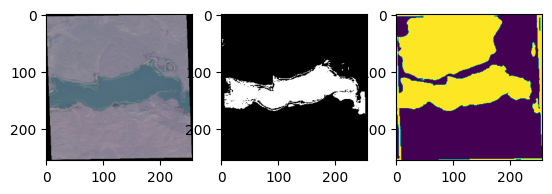

Epochs:12
Train_loss --> Dice: 0.1634722299873829 
Valid_loss --> Dice: 0.1854198310110304


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


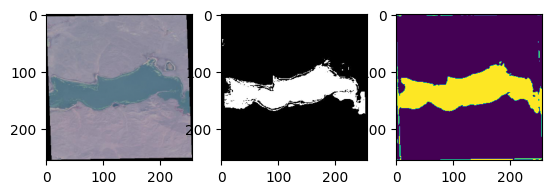

Epochs:13
Train_loss --> Dice: 0.16490693688392638 
Valid_loss --> Dice: 0.15973099735048082
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


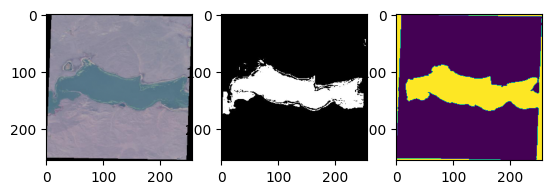

Epochs:14
Train_loss --> Dice: 0.1550968110561371 
Valid_loss --> Dice: 0.15414289633433023
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


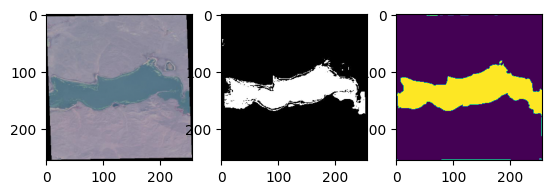

Epochs:15
Train_loss --> Dice: 0.15087899789214135 
Valid_loss --> Dice: 0.14951891369289821
Model Saved


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


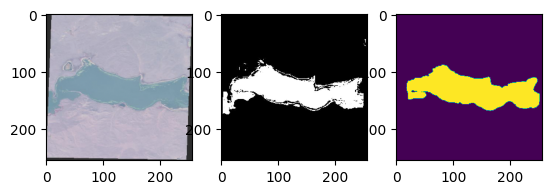

Epochs:16
Train_loss --> Dice: 0.1421595722436905 
Valid_loss --> Dice: 0.14322386185328165
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


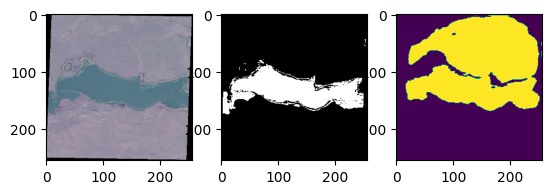

Epochs:17
Train_loss --> Dice: 0.1424274504184723 
Valid_loss --> Dice: 0.23080223136478


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


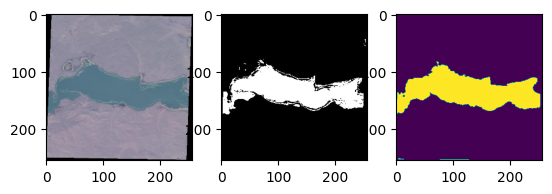

Epochs:18
Train_loss --> Dice: 0.14980080649256705 
Valid_loss --> Dice: 0.15546984142727321


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


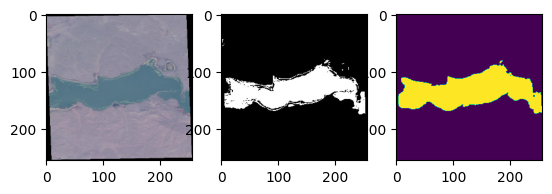

Epochs:19
Train_loss --> Dice: 0.1408946730196476 
Valid_loss --> Dice: 0.15671437978744507


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


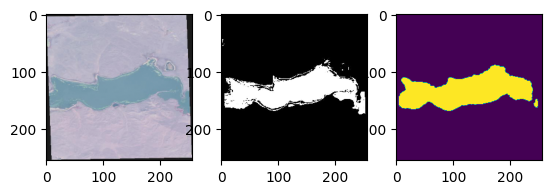

Epochs:20
Train_loss --> Dice: 0.1383054308593273 
Valid_loss --> Dice: 0.15180564588970608


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


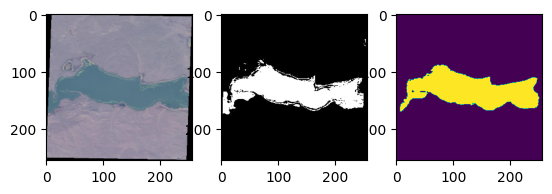

Epochs:21
Train_loss --> Dice: 0.15392594635486603 
Valid_loss --> Dice: 0.17175709538989598


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


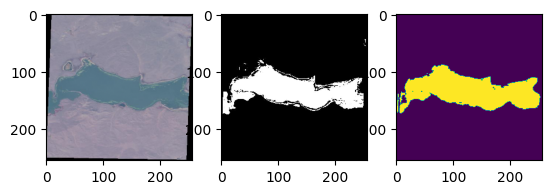

Epochs:22
Train_loss --> Dice: 0.15391515716910362 
Valid_loss --> Dice: 0.1482050683763292


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


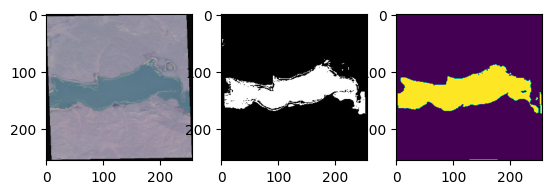

Epochs:23
Train_loss --> Dice: 0.13841800689697265 
Valid_loss --> Dice: 0.14349387089411417


100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


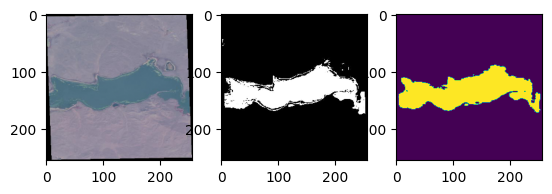

Epochs:24
Train_loss --> Dice: 0.14455011188983918 
Valid_loss --> Dice: 0.13787891467412314
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


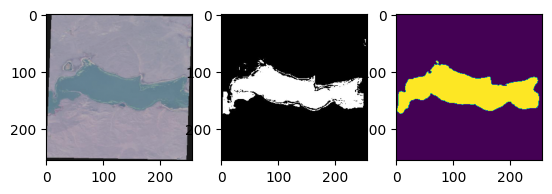

Epochs:25
Train_loss --> Dice: 0.12924949452280998 
Valid_loss --> Dice: 0.14068606826994154


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


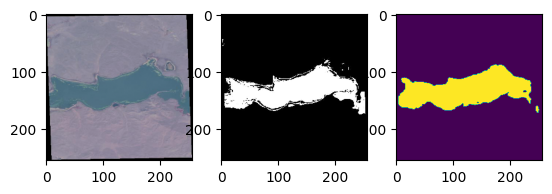

Epochs:26
Train_loss --> Dice: 0.15428717955946922 
Valid_loss --> Dice: 0.2335685027970208


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


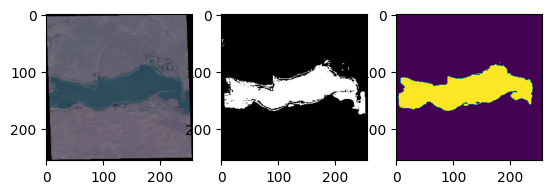

Epochs:27
Train_loss --> Dice: 0.15517986193299294 
Valid_loss --> Dice: 0.1377481288380093
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


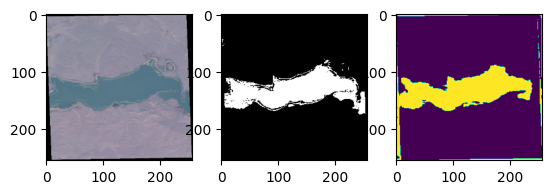

Epochs:28
Train_loss --> Dice: 0.1412274345755577 
Valid_loss --> Dice: 0.15576989783181083


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


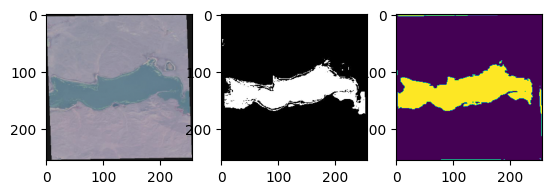

Epochs:29
Train_loss --> Dice: 0.13549775928258895 
Valid_loss --> Dice: 0.13896618949042427


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


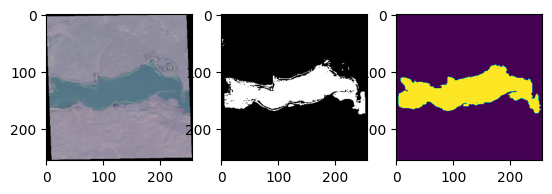

Epochs:30
Train_loss --> Dice: 0.12779465392231942 
Valid_loss --> Dice: 0.1348392499817742
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


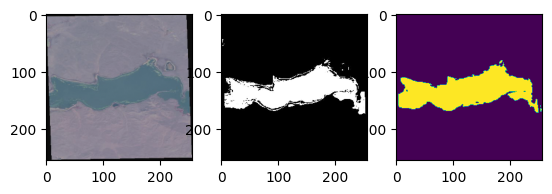

Epochs:31
Train_loss --> Dice: 0.13054793700575829 
Valid_loss --> Dice: 0.1346183485454983
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


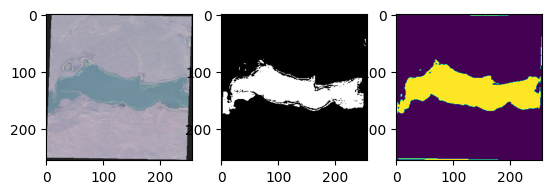

Epochs:32
Train_loss --> Dice: 0.132518021017313 
Valid_loss --> Dice: 0.19167519940270317


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


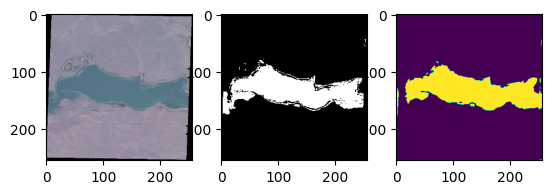

Epochs:33
Train_loss --> Dice: 0.1426366873085499 
Valid_loss --> Dice: 0.1502950456407335


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


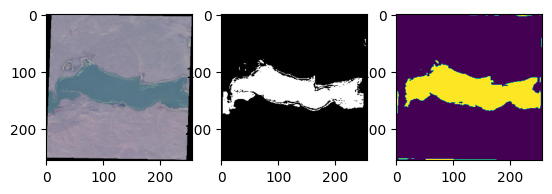

Epochs:34
Train_loss --> Dice: 0.13686061128973961 
Valid_loss --> Dice: 0.1435931921005249


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


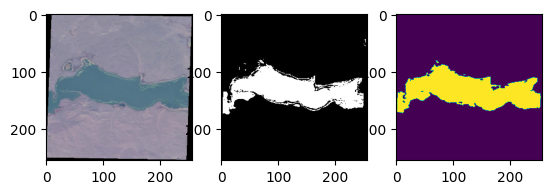

Epochs:35
Train_loss --> Dice: 0.12418589070439338 
Valid_loss --> Dice: 0.13709072271982828


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


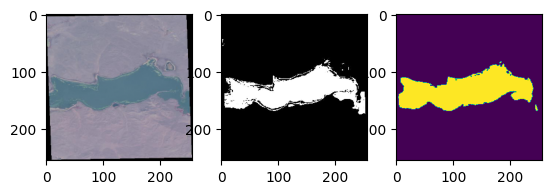

Epochs:36
Train_loss --> Dice: 0.13041002675890923 
Valid_loss --> Dice: 0.1450631022453308


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


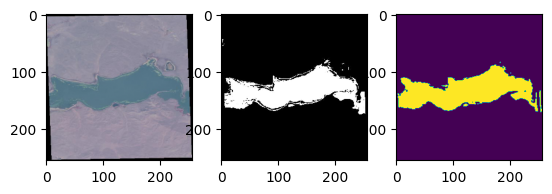

Epochs:37
Train_loss --> Dice: 0.12727344706654548 
Valid_loss --> Dice: 0.13969861798816258


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


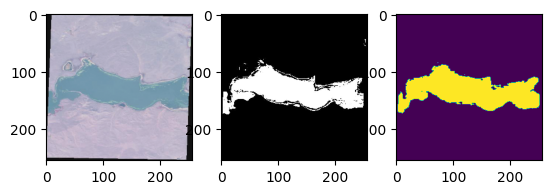

Epochs:38
Train_loss --> Dice: 0.12216795608401299 
Valid_loss --> Dice: 0.12801281611124674
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


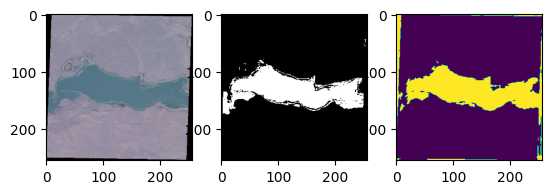

Epochs:39
Train_loss --> Dice: 0.12183001190423966 
Valid_loss --> Dice: 0.13891741302278307


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


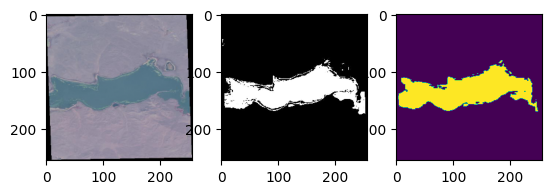

Epochs:40
Train_loss --> Dice: 0.11699441522359848 
Valid_loss --> Dice: 0.14100123776329887


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


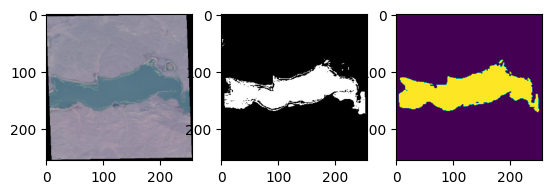

Epochs:41
Train_loss --> Dice: 0.12318008467555046 
Valid_loss --> Dice: 0.13158163097169664


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


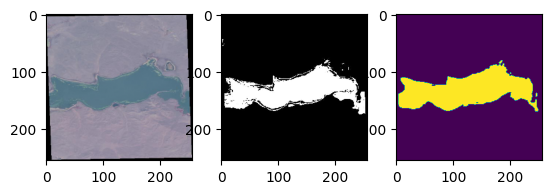

Epochs:42
Train_loss --> Dice: 0.12538660019636155 
Valid_loss --> Dice: 0.1348895099427965


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


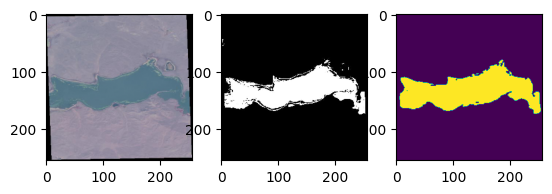

Epochs:43
Train_loss --> Dice: 0.12326170057058335 
Valid_loss --> Dice: 0.13626748985714382


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


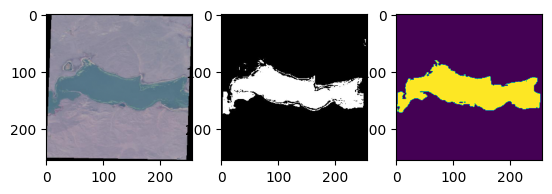

Epochs:44
Train_loss --> Dice: 0.1174999326467514 
Valid_loss --> Dice: 0.13138728009329903


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


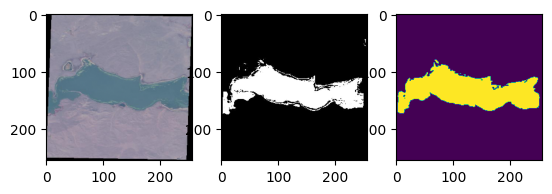

Epochs:45
Train_loss --> Dice: 0.11951417177915573 
Valid_loss --> Dice: 0.1317654914326138


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


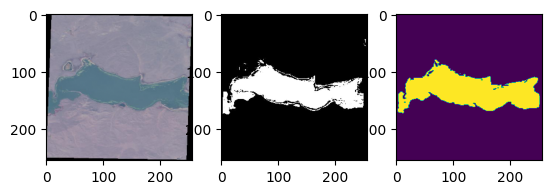

Epochs:46
Train_loss --> Dice: 0.11172939017415047 
Valid_loss --> Dice: 0.14296374056074354


100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


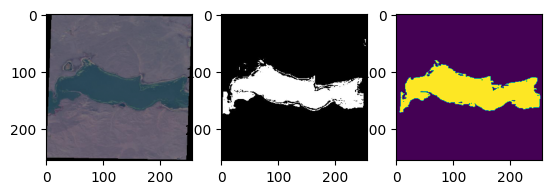

Epochs:47
Train_loss --> Dice: 0.11869646608829498 
Valid_loss --> Dice: 0.1363046964009603


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


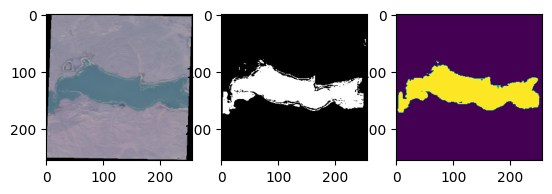

Epochs:48
Train_loss --> Dice: 0.1167945459485054 
Valid_loss --> Dice: 0.12877310646904838


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


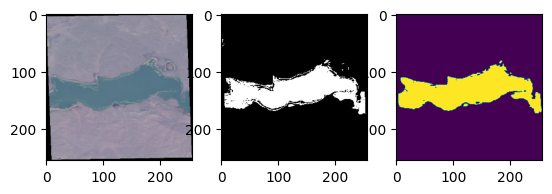

Epochs:49
Train_loss --> Dice: 0.11584241837263107 
Valid_loss --> Dice: 0.13452360365125868


100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


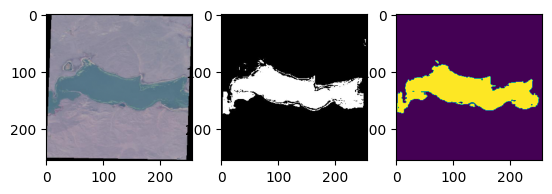

Epochs:50
Train_loss --> Dice: 0.11786219105124474 
Valid_loss --> Dice: 0.14919248554441664


In [21]:
best_val_dice_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)

    train_dice=train_loss
    valid_dice=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} \nValid_loss --> Dice: {valid_dice}')
    
    if valid_dice < best_val_dice_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice

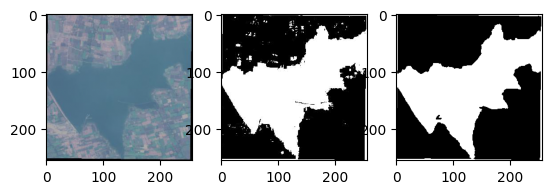

In [31]:
num=10
ratio=0.5

model.load_state_dict(torch.load('./best_model.pt'))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to(device, dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')